In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib as mpl
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import h5py
import sys
sys.path.append('../tools/')
from dust_extinction import calALambda
from data_binning import data_binning
from visual import rcparams_format

rcparams_format(mpl.rcParams)

# SN 2011fe

In [2]:
files = glob.glob('SN2011fe_syn/11fe*')
files.sort()

## Spectra

In [3]:
f = files[0]
hdul = fits.open(f)
hdr = hdul[0].header
hdr

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    1 / number of array dimensions                     
NAXIS1  =                 2691                                                  
EXTEND  =                    T                                                  
CRPIX1  =                    1 / reference pixel                                
CRVAL1  =              3298.68 / coordinate at reference pixel                  
CDELT1  =                 2.38 / coordinate increment per pixel                 
CUNIT1  = 'Angstrom'           / coordinate units                               
CTYPE1  = 'LINEAR  '                                                            
OBJECT  = 'SN2011fe'           / object name                                    
RA      = '14:03:05.73'        / object right ascension                         
DEC     = '54:16:25.18'     

In [4]:
f = files[8]
hdul = fits.open(f)
hdr = hdul[0].header
phase = hdr['tmax']
fl, sig = hdul[0].data, hdul[1].data**.5
wav = np.arange(len(fl)) * float(hdr['CDELT1']) + float(hdr['CRVAL1'])
spec = np.array([wav, fl, sig])

## Filters

In [5]:
P48g = np.loadtxt('P48_g.dat')
P48r = np.loadtxt('P48_R.dat')
P48i = np.loadtxt('P48_I.dat')
SDSSg = np.loadtxt('SLOAN_SDSS.g.dat')

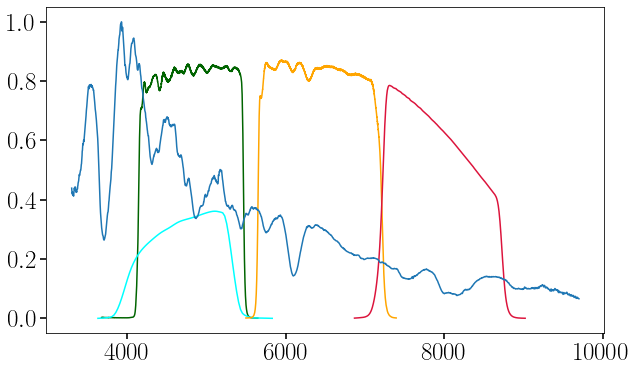

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(P48g[:, 0], P48g[:, 1], color='darkgreen')
plt.plot(SDSSg[:, 0], SDSSg[:, 1], color='cyan')
plt.plot(P48r[:, 0], P48r[:, 1], color='orange')
plt.plot(P48i[:, 0], P48i[:, 1], color='crimson')
plt.plot(wav, fl/np.max(fl))

## Synthetic Photometry

In [3]:
def spec_to_flux(spec, flt):
    try:
        wv, fl, sig = spec[:, ~np.isnan(spec[1])]  # synthetic spectrum
    except:
        wv, fl = spec[:, ~np.isnan(spec[1])]
        sig = fl.copy() * .1
    wv_flt, tra_flt = flt[:, 0], flt[:, 1]  # filter
    fl_flt = np.interp(x=wv_flt, xp=wv, fp=fl)
    var_flt = np.interp(x=wv_flt, xp=wv, fp=sig**2)
    # effective bandwidth
    width = ((wv_flt[1:] - wv_flt[:-1]) * tra_flt[1:]).sum()
    # convolution
    dlambda = wv_flt[1:] - wv_flt[:-1]
    omega = tra_flt[1:] / width * dlambda  # weights
    flux = (fl_flt[1:] * omega).sum()  # erg cm-2 s-1 AA-1
    flux_err = (var_flt[1:] * omega**2).sum()**.5  # erg cm-2 s-1 AA-1
    # effective wavelength
    wv_eff = (wv_flt[1:] * omega).sum()
    flux_Jy = (flux * u.erg / u.cm**2 / u.s / u.AA).to(
        u.Jy, equivalencies=u.spectral_density(wv_eff * u.AA))
    flux_err_Jy = flux_err / flux * flux_Jy
    return flux_Jy.value, flux_err_Jy.value


def spec_to_mag(spec, flt):
    flux, flux_err = spec_to_flux(spec, flt)  # total flux in Jansky

    mag = -2.5 * np.log10(flux / 3631.1)
    mag_unc = -2.5 * np.log10((flux - flux_err) / (flux + flux_err)) / 2
    return mag, mag_unc


In [8]:
Mag, Mag_unc = np.empty((4, len(files))), np.empty((4, len(files)))
Fl, Fl_unc = np.empty((4, len(files))), np.empty((4, len(files)))
T_max, T_fl, MJD = [], [], []
P48g = np.loadtxt('P48_g.dat')
P48r = np.loadtxt('P48_R.dat')
P48i = np.loadtxt('P48_I.dat')
SDSSg = np.loadtxt('SLOAN_SDSS.g.dat')
Flt = [P48g, P48r, P48i, SDSSg]
for j in range(len(files)):
    hdul = fits.open(files[j])
    hdr = hdul[0].header
    T_max = np.append(T_max, float(hdr['tmax']))
    T_fl = np.append(T_fl, float(hdr['txpl']))
    MJD = np.append(MJD, float(hdr['MJD']))
    fl, sig = hdul[0].data, hdul[1].data**.5
    wav = np.arange(len(fl)) * float(hdr['CDELT1']) + float(hdr['CRVAL1'])
    spec = np.array([wav, fl, sig])
    for k in range(4):
        Mag[k, j], Mag_unc[k, j] = spec_to_mag(spec, Flt[k])
        Fl[k, j], Fl_unc[k, j] = spec_to_flux(spec, Flt[k])
arg = np.argsort(T_max)
T_max, T_fl, MJD = T_max[arg], T_fl[arg], MJD[arg]
Mag, Mag_unc = Mag[:, arg], Mag_unc[:, arg]
Fl, Fl_unc = Fl[:, arg], Fl_unc[:, arg]

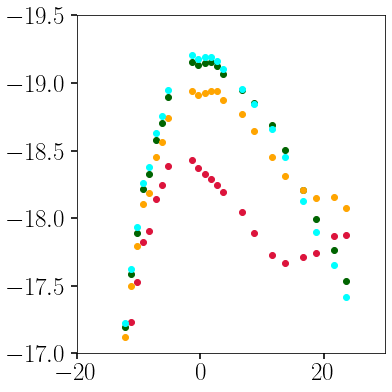

In [9]:
plt.figure(figsize=(6, 6))
plt.errorbar(T_max, Mag[0, :] - 29.04, yerr=Mag_unc[0, :], fmt='o', color='darkgreen')
plt.errorbar(T_max, Mag[1, :] - 29.04, yerr=Mag_unc[1, :], fmt='o', color='orange')
plt.errorbar(T_max, Mag[3, :] - 29.04, yerr=Mag_unc[3, :], fmt='o', color='cyan')
plt.scatter(T_max, Mag[2, :] - 29.04, color='crimson')
plt.xlim(-20, 30)
plt.ylim(-19.5, -17)
plt.gca().invert_yaxis()
plt.tight_layout()

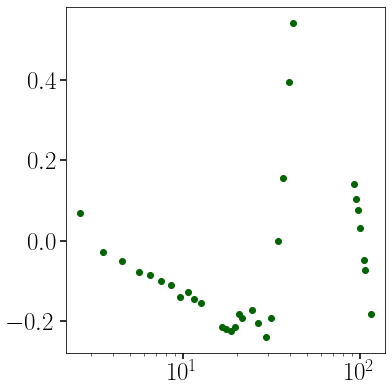

In [10]:
fl_g_r = Fl[0, :]/Fl[1, :]
fl_g_r_unc = (Fl_unc[0, :]**2 + Fl_unc[1, :]**2)**.5
g_r = -2.5 * np.log10(fl_g_r)
g_r_unc = -2.5 * np.log10((fl_g_r - fl_g_r_unc)/(fl_g_r + fl_g_r_unc)) / 2
plt.figure(figsize=(6, 6))
plt.errorbar(T_fl, g_r, yerr=g_r_unc, fmt='o', color='darkgreen')
plt.xscale('log')
plt.tight_layout()

In [11]:
np.savetxt('SN2011fe_g_synthetic.dat',
           np.array([MJD, Mag[0, :], Mag_unc[0, :]]).T)
np.savetxt('SN2011fe_r_synthetic.dat',
           np.array([MJD, Mag[1, :], Mag_unc[1, :]]).T)
np.savetxt('SN2011fe_g_r_synthetic.dat',
           np.array([MJD, g_r, g_r_unc]).T)

# DDet Models

0.94 0.05 [23.5]
0.95 0.045 [23.5]
0.95 0.055 [23.5]


/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_96376/3058013104.py:21: RuntimeWarning: invalid value encountered in double_scalars
  flux_err_Jy = flux_err / flux * flux_Jy
/var/folders/_g/qsrvvtv17zn3wk8jrrrfhmx80000gn/T/ipykernel_96376/3058013104.py:28: RuntimeWarning: divide by zero encountered in log10
  mag = -2.5 * np.log10(flux / 3631.1)


0.95 0.05 [23.5]
0.96 0.05 [23.5]
0.9 0.05 [20.5]
0.9 0.08 [16.5]
1.0 0.01 [19.5]
1.0 0.02 [20.5]


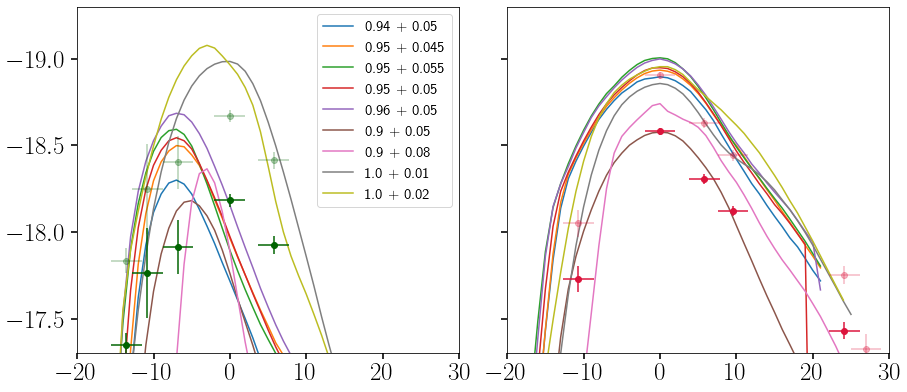

In [28]:
models = glob.glob('../../DoubleDetonationModels/Polin2019/spectra/*h5')
models.sort()
fig, ax = plt.subplots(1, 2, figsize=(13, 6), sharey=True, sharex=True)
for model in models:
    with h5py.File(model, 'r') as f:
        mc, ms = model.split('_')[1], model.split('_')[2]
        if not (0.94 <= float(mc) + float(ms) <= 1.03):
            continue
        Lnu = np.array(f['Lnu']) * u.erg / u.s / u.Hz
        Fnu = Lnu / (4 * np.pi * (10 * u.pc)**2)
        time = np.array(f['time'][:] / 86400)
        nu = np.array(f['nu'][:])
        wv0 = np.flip((c.c / nu / u.Hz).to(u.AA).value)
        wv = wv0 * (1 + 0.0307)
        Flam = np.array([(np.flip(fnu)).to(u.erg / u.s / u.cm**2 / u.AA,
                                           equivalencies=u.spectral_density(
                                               wv * u.AA))
                         for fnu in Fnu]) / (1 + 0.0307)
    Mag, Mag_unc = np.empty((2, len(time))), np.empty((2, len(time)))
    Fl, Fl_unc = np.empty((2, len(time))), np.empty((2, len(time)))
    T_fl = time
    Flt = [P48g, P48r]
    for j in range(len(time)):
        fl = Flam[j]
        if not (1 < time[j] < 45):
            Mag[:, j], Mag_unc[:, j] = np.nan, np.nan
            Fl[:, j], Fl_unc[:, j] = 0, 0
        else:
            spec = np.array([wv, fl, fl / 100])
            for k in range(2):
                Mag[k, j], Mag_unc[k, j] = spec_to_mag(spec, Flt[k])
                Fl[k, j], Fl_unc[k, j] = spec_to_flux(spec, Flt[k])
    if np.nanmin(Mag[1]) > -18.4 or np.nanmin(Mag[1]) < -19.05 or np.nanmin(
            Mag[0]) > -18. or np.nanmin(Mag[0]) < -19.1:
        continue
    g_bin = data_binning(np.array([time, Mag[0], np.ones_like(time)]).T, size=1)
    r_bin = data_binning(np.array([time, Mag[1], np.ones_like(time)]).T, size=1)
    t_rmax = r_bin[[np.nanargmin(r_bin[:, 1])], 0]
    print(mc, ms, t_rmax)
    ax[0].plot(g_bin[:, 0] - t_rmax, g_bin[:, 1], label='{} + {}'.format(mc, ms))
    ax[1].plot(r_bin[:, 0] - t_rmax, r_bin[:, 1])

g_lc = np.loadtxt('../lc/SN2020jgb_ZTF_g_snr2.dat')
g_lc = g_lc[g_lc[:, 2] > 0]
r_lc = np.loadtxt('../lc/SN2020jgb_ZTF_r_snr2.dat')
r_lc = r_lc[r_lc[:, 2] > 0]
t_rmax = r_lc[np.argmin(r_lc[:, 1]), 0]
t_fl = 58969.47021
ax[0].errorbar((g_lc[:, 0] - t_rmax) / (1 + 0.0307),
               g_lc[:, 1] - 0.488,
               xerr=2,
               yerr=g_lc[:, 2],
               fmt='o',
               color='darkgreen',
               alpha=.3)
ax[0].errorbar((g_lc[:, 0] - t_rmax) / (1 + 0.0307),
               g_lc[:, 1],
               xerr=2,
               yerr=g_lc[:, 2],
               fmt='o',
               color='darkgreen')
ax[1].errorbar((r_lc[:, 0] - t_rmax) / (1 + 0.0307),
               r_lc[:, 1] - .322,
               xerr=2,
               yerr=r_lc[:, 2],
               fmt='o',
               color='crimson',
               alpha=.3)
ax[1].errorbar((r_lc[:, 0] - t_rmax) / (1 + 0.0307),
               r_lc[:, 1],
               xerr=2,
               yerr=r_lc[:, 2],
               fmt='o',
               color='crimson')
ax[0].legend(prop={'size': 15})
ax[0].invert_yaxis()
ax[1].invert_yaxis()
ax[0].set_ylim(-17.3, -19.3)
ax[1].set_xlim(-20, 30)
fig.tight_layout()

## K-corrections

### 20jgb

In [14]:
spec_NOT = np.loadtxt('../spectroscopy/SN2020jgb/ZTF20aayhacx_20200513_NOT_v4.ascii').T
spec_Lick = np.loadtxt('../spectroscopy/SN2020jgb/ZTF20aayhacx_20200529_Lick_3-m_v1.ascii').T
spec_Keck = np.loadtxt('../spectroscopy/SN2020jgb/ZTF20aayhacx_20200623_Keck1_v1.ascii').T
spec_Keck = spec_Keck[[0, 1, 3]]

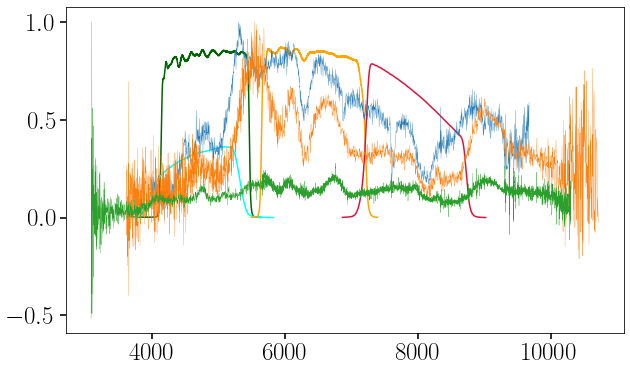

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(P48g[:, 0], P48g[:, 1], color='darkgreen')
plt.plot(SDSSg[:, 0], SDSSg[:, 1], color='cyan')
plt.plot(P48r[:, 0], P48r[:, 1], color='orange')
plt.plot(P48i[:, 0], P48i[:, 1], color='crimson')
plt.plot(spec_NOT[0, :], spec_NOT[1, :]/np.max(spec_NOT[1, :]), linewidth=.3)
plt.plot(spec_Lick[0, :], spec_Lick[1, :]/np.max(spec_Lick[1, :]), linewidth=.3)
plt.plot(spec_Keck[0, :], spec_Keck[1, :]/np.nanmax(spec_Keck[1, :]), linewidth=.3)

In [12]:
def K_corr(spec, z, flt):
    spec_rest = spec.copy()
    spec_rest[0, :] = spec[0, :] / (1 + z)
    f, f_unc = spec_to_flux(spec, flt)
    f_rest, f_rest_unc = spec_to_flux(spec_rest, flt)
    f_rest_f = f_rest / f
    f_rest_f_unc = f_rest_f * ((f_unc / f)**2 + (f_rest_unc / f_rest)**2)**.5
    K_corr = -2.5 * np.log10(f_rest_f)
    K_corr_unc = -2.5 / 2 * np.log10(
        (f_rest_f - f_rest_f_unc) / (f_rest_f + f_rest_f_unc))
    print('K-correction: {:.3f} +/- {:.3f}'.format(K_corr, K_corr_unc))


def color(spec, flt1, flt2, A1=0, A2=0):
    f1, f1_unc = spec_to_flux(spec, flt1)
    f2, f2_unc = spec_to_flux(spec, flt2)
    f1_f2 = f1 / f2
    f1_f2_unc = f1_f2 * ((f1_unc / f1)**2 + (f2_unc / f2)**2)**.5
    flt1_flt2 = -2.5 * np.log10(f1 / f2) - (A1 - A2)
    flt1_flt2_unc = -2.5 / 2 * np.log10(
        (f1_f2 - f1_f2_unc) / (f1_f2 + f1_f2_unc))
    print('color: {:.3f} +/- {:.3f}'.format(flt1_flt2, flt1_flt2_unc))


In [10]:
leff_g = 4722.74  #AA
leff_r = 6339.61  #AA
leff_i = 7886.13  #AA
rv = 3.1
ebv = 0.404
ebv_host = 0.13
Ag = calALambda(leff_g, rv, ebv)
Ar = calALambda(leff_r, rv, ebv)
Ai = calALambda(leff_r, rv, ebv)
calALambda(leff_g, rv, ebv_host), calALambda(leff_r, rv, ebv_host), calALambda(leff_i, rv, ebv_host)

(0.4881165820350736, 0.3223470460701907, 0.22780804137582453)

In [24]:
spec_P60 = np.loadtxt('../spectroscopy/SN2020jgb/ZTF20aayhacx_20200521_P60_v2.ascii').T
spec_P60[2] = spec_P60[2]**.5
print(spec_to_mag(spec_P60, flt=P48g)[0] - Ag - 35.67, spec_to_mag(spec_P60, flt=P48g)[1])
print(spec_to_mag(spec_P60, flt=P48r)[0] - Ar - 35.67, spec_to_mag(spec_P60, flt=P48r)[1])
spec_P60 = np.loadtxt('../spectroscopy/SN2020jgb/ZTF20aayhacx_20200528_P60_v2.ascii').T
spec_P60[2] = spec_P60[2]**.5
print(spec_to_mag(spec_P60, flt=P48g)[0] - Ag - 35.67, spec_to_mag(spec_P60, flt=P48g)[1])
print(spec_to_mag(spec_P60, flt=P48r)[0] - Ar - 35.67, spec_to_mag(spec_P60, flt=P48r)[1])

-18.1209827079362 0.005120926459753792
-18.684145510018627 0.001762998763925795
-17.83888250080071 0.005148510581399614
-18.242833509033872 0.0017280629984727338


In [15]:
print('NOT (-4 d)')
print('ZTF g')
K_corr(spec_NOT, z=0.0307, flt=P48g)
print('ZTF r')
K_corr(spec_NOT, z=0.0307, flt=P48r)
print('ZTF g - r')
color(spec_NOT, flt1=P48g, flt2=P48r, A1=Ag, A2=Ar)
print('ZTF r - i')
color(spec_NOT, flt1=P48r, flt2=P48i, A1=Ar, A2=Ai)

print('Lick (+12 d)')
print('ZTF g')
K_corr(spec_Lick, z=0.0307, flt=P48g)
print('ZTF r')
K_corr(spec_Lick, z=0.0307, flt=P48r)
print('ZTF g - r')
color(spec_Lick, flt1=P48g, flt2=P48r, A1=Ag, A2=Ar)
print('ZTF r - i')
color(spec_Lick, flt1=P48r, flt2=P48i, A1=Ar, A2=Ai)

print('Keck (+36 d)')
print('ZTF g')
K_corr(spec_Keck, z=0.0307, flt=P48g)
print('ZTF r')
K_corr(spec_Keck, z=0.0307, flt=P48r)
print('ZTF g - r')
color(spec_Keck, flt1=P48g, flt2=P48r, A1=Ag, A2=Ar)
print('ZTF r - i')
color(spec_Keck, flt1=P48r, flt2=P48i, A1=Ar, A2=Ai)

NOT (-4 d)
ZTF g
K-correction: -0.157 +/- 0.003
ZTF r
K-correction: 0.048 +/- 0.001
ZTF g - r
color: 0.634 +/- 0.002
ZTF r - i
color: -0.128 +/- 0.002
Lick (+12 d)
ZTF g
K-correction: -0.263 +/- 0.008
ZTF r
K-correction: 0.099 +/- 0.004
ZTF g - r
color: 0.720 +/- 0.007
ZTF r - i
color: -0.204 +/- 0.006
Keck (+36 d)
ZTF g
K-correction: -0.085 +/- 0.005
ZTF r
K-correction: 0.048 +/- 0.003
ZTF g - r
color: 0.477 +/- 0.004
ZTF r - i
color: 0.230 +/- 0.004


In [24]:
P60_files = glob.glob('../spectroscopy/SN2020jgb/*P60*')
P60_files.sort()
for file in P60_files:
    date = file.split('_')[1]
    print(date)
    spec_P60 = np.loadtxt(file).T
    spec_P60[2] = spec_P60[2]**.5
    color(spec_P60, flt1=P48g, flt2=P48r, A1=Ag, A2=Ar)

20200507
color: -0.209 +/- 0.011
20200521
color: 0.563 +/- 0.005
20200528
color: 0.404 +/- 0.005
20200608
color: -0.294 +/- 0.012


### 18byg

In [16]:
spec_Keck1 = np.loadtxt('../spectroscopy/SN2018byg/ZTF18aaqeasu_20180514_Keck1_v1.ascii').T
spec_P200 = np.loadtxt('../spectroscopy/SN2018byg/ZTF18aaqeasu_20180517_P200_v2.ascii').T
spec_Keck2 = np.loadtxt('../spectroscopy/SN2018byg/ZTF18aaqeasu_20180617_Keck1_v1.ascii').T
spec_Keck1 = spec_Keck1[[0, 1, 3]]
spec_Keck2 = spec_Keck2[[0, 1, 3]]

(5000.0, 6000.0)

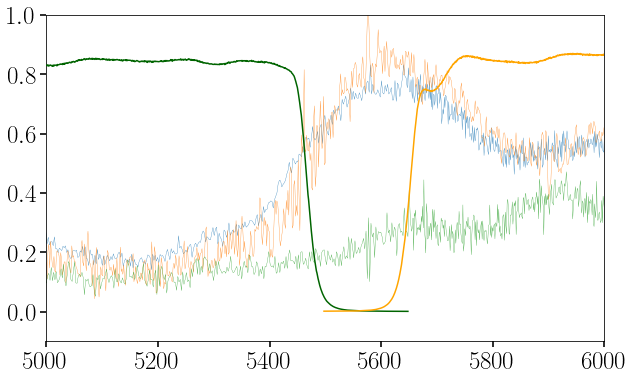

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(P48g[:, 0], P48g[:, 1], color='darkgreen', zorder=10)
#plt.plot(SDSSg[:, 0], SDSSg[:, 1], color='cyan')
plt.plot(P48r[:, 0], P48r[:, 1], color='orange', zorder=10)
plt.plot(P48i[:, 0], P48i[:, 1], color='crimson')
plt.plot(spec_Keck1[0, :], spec_Keck1[1, :]/np.nanmax(spec_Keck1[1, :]), linewidth=.3)
plt.plot(spec_P200[0, :], spec_P200[1, :]/np.max(spec_P200[1, :]), linewidth=.3)
plt.plot(spec_Keck2[0, :], spec_Keck2[1, :]/np.nanmax(spec_Keck2[1, :]), linewidth=.3)
plt.ylim(-0.1, 1)
plt.xlim(5000, 6000)

In [17]:
print('Keck (-5 d)')
print('ZTF g')
K_corr(spec_Keck1, z=0.066, flt=P48g)
print('ZTF r')
K_corr(spec_Keck1, z=0.066, flt=P48r)
print('ZTF r - i')
color(spec_Keck1, flt1=P48r, flt2=P48i, A1=Ar, A2=Ai)

print('DBSP (-2 d)')
print('ZTF g')
K_corr(spec_P200, z=0.066, flt=P48g)
print('ZTF r')
K_corr(spec_P200, z=0.066, flt=P48r)
print('ZTF r - i')
color(spec_P200, flt1=P48r, flt2=P48i, A1=Ar, A2=Ai)

print('Keck (+27 d)')
print('ZTF g')
K_corr(spec_Keck2, z=0.066, flt=P48g)
print('ZTF r')
K_corr(spec_Keck2, z=0.066, flt=P48r)
print('ZTF r - i')
color(spec_Keck2, flt1=P48r, flt2=P48i, A1=Ar, A2=Ai)

Keck (-5 d)
ZTF g
K-correction: -0.585 +/- 0.003
ZTF r
K-correction: 0.109 +/- 0.001
ZTF r - i
color: -0.233 +/- 0.002
DBSP (-2 d)
ZTF g
K-correction: -0.808 +/- 0.005
ZTF r
K-correction: 0.144 +/- 0.003
ZTF r - i
color: -0.282 +/- 0.005
Keck (+27 d)
ZTF g
K-correction: -0.232 +/- 0.006
ZTF r
K-correction: 0.284 +/- 0.004
ZTF r - i
color: -0.315 +/- 0.007
